<a href="https://colab.research.google.com/github/JoaoVitorSantiagoNogueira/deepLearning2023/blob/main/T2/Task_2_DL_U_Net_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Fontes

[1] https://debuggercafe.com/unet-from-scratch-using-pytorch/

[2] https://towardsdatascience.com/cook-your-first-u-net-in-pytorch-b3297a844cf3

[3] https://www.learnpytorch.io/04_pytorch_custom_datasets/

[4] https://github.com/DIAGNijmegen/drive-vessels-unet/blob/master/dataloader.py

##Exportar

In [ ]:
!pip install nbconvert
!jupyter nbconvert --to html /content/Task_2_DL_U_Net_.ipynb

[NbConvertApp] Converting notebook /content/Task_2_DL_U_Net_.ipynb to html
[NbConvertApp] Writing 1482748 bytes to /content/Task_2_DL_U_Net_.html


# Executar tudo


##Inicializar o Código

### Bibliotecas

In [ ]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
from PIL import Image
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

import requests
import zipfile
from pathlib import Path

import os
import sys
from glob import glob

###Rede
U-NET

In [ ]:
def double_convolution(in_channels, out_channels):
    """
    In the original paper implementation, the convolution operations were
    not padded but we are padding them here. This is because, we need the
    output result size to be same as input size.
    """
    conv_op = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True)
    )
    return conv_op

In [ ]:
class UNet(nn.Module):
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        # Contracting path.
        # Each convolution is applied twice.
        self.down_convolution_1 = double_convolution(3, 64)
        self.down_convolution_2 = double_convolution(64, 128)
        self.down_convolution_3 = double_convolution(128, 256)
        self.down_convolution_4 = double_convolution(256, 512)
        self.down_convolution_5 = double_convolution(512, 1024)
        # Expanding path.
        self.up_transpose_1 = nn.ConvTranspose2d(
            in_channels=1024, out_channels=512,
            kernel_size=2,
            stride=2)
        # Below, `in_channels` again becomes 1024 as we are concatinating.
        self.up_convolution_1 = double_convolution(1024, 512)
        self.up_transpose_2 = nn.ConvTranspose2d(
            in_channels=512, out_channels=256,
            kernel_size=2,
            stride=2)
        self.up_convolution_2 = double_convolution(512, 256)
        self.up_transpose_3 = nn.ConvTranspose2d(
            in_channels=256, out_channels=128,
            kernel_size=2,
            stride=2)
        self.up_convolution_3 = double_convolution(256, 128)
        self.up_transpose_4 = nn.ConvTranspose2d(
            in_channels=128, out_channels=64,
            kernel_size=2,
            stride=2)
        self.up_convolution_4 = double_convolution(128, 64)
        # output => `out_channels` as per the number of classes.
        self.out = nn.Conv2d(
            in_channels=64, out_channels=num_classes,
            kernel_size=1
        )
    def forward(self, x):
        down_1 = self.down_convolution_1(x)
        down_2 = self.max_pool2d(down_1)
        down_3 = self.down_convolution_2(down_2)
        down_4 = self.max_pool2d(down_3)
        down_5 = self.down_convolution_3(down_4)
        down_6 = self.max_pool2d(down_5)
        down_7 = self.down_convolution_4(down_6)
        down_8 = self.max_pool2d(down_7)
        down_9 = self.down_convolution_5(down_8)
        # *** DO NOT APPLY MAX POOL TO down_9 ***

        up_1 = self.up_transpose_1(down_9)
        x = self.up_convolution_1(torch.cat([down_7, up_1], 1))
        up_2 = self.up_transpose_2(x)
        x = self.up_convolution_2(torch.cat([down_5, up_2], 1))
        up_3 = self.up_transpose_3(x)
        x = self.up_convolution_3(torch.cat([down_3, up_3], 1))
        up_4 = self.up_transpose_4(x)
        x = self.up_convolution_4(torch.cat([down_1, up_4], 1))
        out = self.out(x)
        return out

[4] Vizualiza o número de parâmetros das rede. Numero de parametros:

### DATASET

#### Download

usando [3] podemos realizar o download do dataset diretamente do drive e extrai-lo para o uso. Podemos então usar [4] para transformar essa estrutura de arquivos na forma de dataset

In [ ]:
# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "RETINA"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "RETINA.zip", "wb") as f:
        request = requests.get("https://drive.google.com/u/0/uc?id=10Uy_UT0JgjCTCcirzTGs5_nNDmH_MryX&export=download&confirm=t&uuid=211af45b-bdaa-4f76-aed9-5c786d7173e4&at=AB6BwCALI4ZjjkzYftiUni1t1842:1697461941658")
        print("Downloading dataset...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "RETINA.zip", "r") as zip_ref:
        print("Unzipping dataset...")
        zip_ref.extractall(image_path)


TRAIN_IMAGE_ROOT = "./data/RETINA/training/input"
TRAIN_LABEL_ROOT = "./data/RETINA/training/target"

TEST_IMAGE_ROOT = "./data/RETINA/test/input"
TEST_LABEL_ROOT = "./data/RETINA/test/target"

images = sorted(glob(os.path.join(TRAIN_IMAGE_ROOT, "*training.tif")))
labels = sorted(glob(os.path.join(TRAIN_LABEL_ROOT, "*manual1.png")))

testimages = sorted(glob(os.path.join(TEST_IMAGE_ROOT, "*test.tif")))
testlabels = sorted(glob(os.path.join(TEST_LABEL_ROOT, "*manual1.gif")))






Did not find data/RETINA directory, creating one...
Unzipping dataset...


In [ ]:
class DRIVEDataset(Dataset):
    """DRIVE dataset."""

    def __init__(self, image_files, label_files, transform=None):
        """

        :param image_files:
        :param label_files:
        :param transform:
        """
        self.image_files = image_files
        self.label_files = label_files
        self.transform = transform

        print("Initialized propperly")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.image_files[idx]
        seg_name = self.label_files[idx]

        image = Image.open(img_name)
        label = Image.open(seg_name)

        if self.transform:
            image = self.transform(image)
            label = self.transform(label)

        sample = {"img": image, "seg": label}

        #return sample
        return image, label

#### tranformações
De [4] definimos operações para as transformações, e elas em si

In [ ]:
transform = transforms.Compose([
    transforms.Resize((512,512)),
    transforms.ToTensor(),
])

img_transform = transforms.Compose([
    transforms.Resize((512,512)),
    transforms.ToPILImage(),
])

#### Definição dos data sets

In [ ]:
train_ds = DRIVEDataset(images, labels, transform=transform)
valid_ds = DRIVEDataset(testimages, testlabels, transform=transform)

batchSize = 4

train_loader = DataLoader(
    train_ds, batch_size=batchSize, shuffle=True, num_workers=0, pin_memory=True,
)

test_loader = DataLoader(
    valid_ds, batch_size=batchSize, shuffle=True, num_workers=0, pin_memory=True,
)

Initialized propperly
Initialized propperly


## Vizualização dos dados

#### Sanity Check

torch.Size([4, 3, 512, 512])
31,031,745 total parameters.
31,031,745 training parameters.
torch.Size([1, 1, 512, 512])


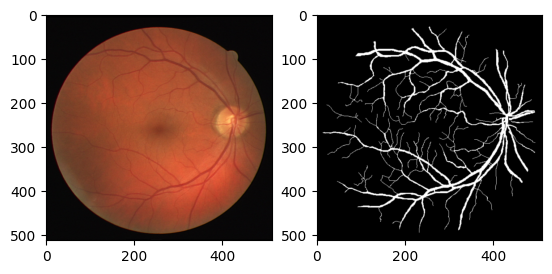

In [ ]:
input_image = torch.rand((1, 3, 512, 512))
check_model = UNet(num_classes=1)

a = next(iter(train_loader))
print (a[0].size())
len(train_ds)
# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in check_model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in check_model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")


outputs = check_model(input_image)
print(outputs.shape)

for test_images, test_labels in test_loader:
    sample_image = test_images[0]    # Reshape them according to your needs.
    sample_label = test_labels[0]
#sample = img_transform(sample_image)
f, axarr = plt.subplots(1,2)

axarr[0].imshow(sample_image.permute(1, 2, 0))
axarr[1].imshow(sample_label.permute(1, 2, 0), cmap="gray")

testa o resultado de output, por enquanto lixo.

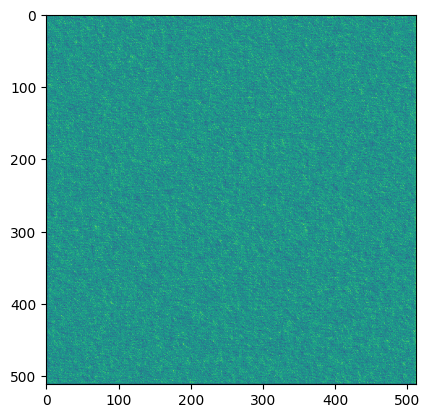

In [ ]:
plt.imshow(outputs.detach().numpy()[0,0,:,:].T)

## GPU
[5][6]temos/queremos tirar vantagem da GPU do google para acelerar o treinamento, logo temos que habilitar essas funcionalidades

In [ ]:
print(torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

True


## Execução

### Definir Modelos

In [ ]:
loss_function = F.binary_cross_entropy_with_logits
learning_rate = 0.001

In [ ]:
model = UNet(1)##sigle class, soa estranho, mas essa é a forma da imagem
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

UNet(
  (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down_convolution_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (down_convolution_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (down_convolution_3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (down_convolution_4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(51

### Treinamento

####Setup

In [ ]:
def trainModel(model, optimizer, num_epochs):
    # start a typical PyTorch training
    epochs_total = num_epochs
    val_interval = 1
    best_loss = np.inf
    best_metric_epoch = -1
    epoch_loss_values = list()
    #metric_values = list()
    writer = SummaryWriter()
    for epoch in range(epochs_total):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{epochs_total}")
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step += 1
            inputs, labels, weights = (
                        #batch_data["img"].to(device),
                        batch_data[0].to(device),
                        #batch_data["seg"].to(device),
                        batch_data[1].to(device),
                        #batch_data["map"].to(device),
                        0,
            )
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = loss_function(outputs, labels[:,0,:,:])
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            epoch_len = len(train_ds) // train_loader.batch_size
            print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
            writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                epoch_val_loss = []
                val_images = None
                val_labels = None
                val_outputs = None
                for val_data in test_loader:
                    val_images, val_labels, val_weights = (
                        #val_data["img"].to(device),
                        val_data[0].to(device),
                        #val_data["seg"].to(device),
                        val_data[1].to(device),
                        #val_data["map"].to(device),
                        0,
                    )
                    val_outputs = model(val_images).squeeze()
                    loss = loss_function(val_outputs, val_labels[:,0,:,:])
                    epoch_val_loss.append(loss.item())
                epoch_val_loss = np.array(epoch_val_loss).mean()
                if epoch_val_loss < best_loss:
                    best_loss = epoch_val_loss
                    best_metric_epoch = epoch + 1
                    torch.save(
                        model.state_dict(), "best_metric_model_segmentation2d_dict.pth"
                    )
                    print("saved new best metric model")
                print(
                    "current epoch: {} current val loss: {:.4f} best val loss: {:.4f} at epoch {}".format(
                        epoch + 1, epoch_val_loss, best_loss, best_metric_epoch
                    )
                )
                writer.add_scalar("val_loss", epoch_val_loss, epoch + 1)
                # plot the last model output as GIF image in TensorBoard with the corresponding image and label
                #plot_2d_or_3d_image(val_images, epoch + 1, writer, index=0, tag="image")
                #plot_2d_or_3d_image(val_labels, epoch + 1, writer, index=0, tag="label")
                #plot_2d_or_3d_image(
                #    val_outputs, epoch + 1, writer, index=0, tag="output"
                #)

    print(f"train completed, best_loss: {best_loss:.4f} at epoch: {best_metric_epoch}")
    writer.close()
    return epoch_loss_values

#### Training

In [ ]:
losses = trainModel(model, optimizer,50)
#loss_list = [i.cpu().numpy() for i in loss_list]
#iteration_list, loss_list, accuracy_list, predictions_list, labels_list = trainModel(model, optimizer,1)
#loss_list = [i.cpu().numpy() for i in loss_list]
#accuracy_list = [i.cpu().numpy() for i in accuracy_list]

----------
epoch 1/50
1/5, train_loss: 0.6568
2/5, train_loss: 0.6406
3/5, train_loss: 0.6138
4/5, train_loss: 0.5677
5/5, train_loss: 0.4082
epoch 1 average loss: 0.5774
saved new best metric model
current epoch: 1 current val loss: 12.8908 best val loss: 12.8908 at epoch 1
----------
epoch 2/50
1/5, train_loss: 11.6031
2/5, train_loss: 0.3675
3/5, train_loss: 0.4534
4/5, train_loss: 0.4922
5/5, train_loss: 0.5186
epoch 2 average loss: 2.6869
saved new best metric model
current epoch: 2 current val loss: 0.5320 best val loss: 0.5320 at epoch 2
----------
epoch 3/50
1/5, train_loss: 0.5373
2/5, train_loss: 0.5416
3/5, train_loss: 0.5497
4/5, train_loss: 0.5443
5/5, train_loss: 0.5375
epoch 3 average loss: 0.5420
saved new best metric model
current epoch: 3 current val loss: 0.5241 best val loss: 0.5241 at epoch 3
----------
epoch 4/50
1/5, train_loss: 0.5252
2/5, train_loss: 0.4333
3/5, train_loss: 0.4123
4/5, train_loss: 0.3459
5/5, train_loss: 0.3801
epoch 4 average loss: 0.4193
save

torch.Size([1, 3, 512, 512])
tensor(0.2795, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


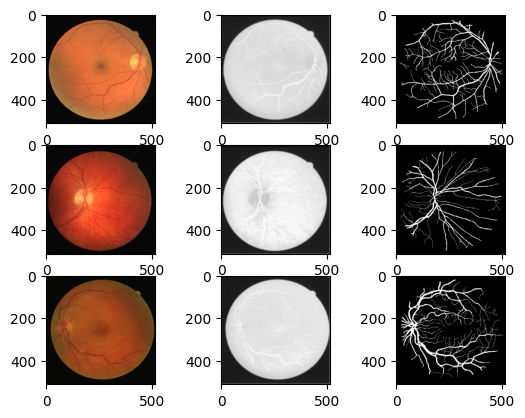

In [ ]:
print(sample_image.unsqueeze(0).size())

tests_count = 3

sample_images =[]
sample_label  =[]

f, axarr = plt.subplots(tests_count,3)

for test_images, test_labels in test_loader:
  for i in range (0, tests_count):
    sample_image = test_images[i]    # Reshape them according to your needs.
    sample_label = test_labels[i]
    outputs = model(sample_image.unsqueeze(0).to(device))
    axarr[i,1].imshow(outputs.cpu().detach().permute(2, 3, 0, 1).numpy()[:,:,0,0], cmap="gray")
    axarr[i,0].imshow(sample_image.permute(1, 2, 0))
    axarr[i,2].imshow(sample_label.permute(1, 2, 0), cmap="gray")

print(loss_function(outputs[:,0,:,:], sample_label.to(device)))

### Vizualização

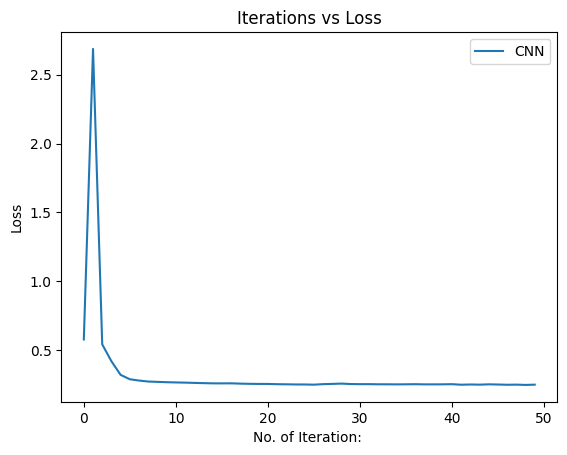

In [ ]:
def plotLoss(iter, loss1):
  plt.plot(iter, loss1, label = "CNN")
  plt.xlabel("No. of Iteration: ")
  plt.ylabel("Loss")
  plt.title("Iterations vs Loss")
  plt.legend()
  plt.show()

plotLoss(range(0,50),losses)